In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score



from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

plt.rcParams['figure.figsize'] = (14, 10)


import warnings
warnings.filterwarnings("ignore")

## 1. Import the data

In [3]:
df= pd.read_csv("insurance_cost.csv")

df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
cat_cols = ["sex", "smoker", "region"]

## 2. Train a baseline model
### Linear Regression

In [22]:


def  label_encoder(df, cat_cols, drop_true_or_false=True):
    label_enc = LabelEncoder()
    for cat in cat_cols:
        df[cat] = label_enc.fit_transform(df[cat])
    return df

def one_hot_encode(df, cat_cols, drop_true_or_false=True):
    df = pd.get_dummies(df, columns=cat_cols, drop_first=drop_true_or_false)
    return df


def splitting(df, target):
    X = df.drop(target, axis=1)
    y= df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    return X_train, X_test, y_train, y_test

def model_fitting(model, df, target, cat_cols):
    df = label_encoder(df, cat_cols)
    X_train, X_test, y_train, y_test = splitting(df, target)

    m = model()
    m.fit(X_train,y_train)
    pred_train = m.predict(X_train)
    pred_test = m.predict(X_test)

    r2_score_train = metrics.r2_score(y_train, pred_train)
    print("r2_score of train", r2_score_train)

    r2_score_test = metrics.r2_score(y_test, pred_test)
    print("r2_score of test", r2_score_test)

    return m , r2_score_train, r2_score_test

In [23]:
model , r2_score_train, r2_score_test,  = model_fitting(LinearRegression, df, "charges", cat_cols)

(1070, 6) (268, 6) (1070,) (268,)
r2_score of train 0.7417049283233981
r2_score of test 0.7833463107364538


## 3. Compare different models to establish the best model.

In [11]:
models = [
    ["XGB Boost", XGBRegressor],
    ["Linear Regression", LinearRegression],
    ["Ridge", Ridge], 
    ["Lasso", Lasso],
    ["Decision Tree", DecisionTreeRegressor],
    ["Random Forrest", RandomForestRegressor], 
    ["Extra Tree", ExtraTreesRegressor]
    ]

In [12]:
def model_fitting(model, df, target, cat_cols, encoder, drop_true_or_false = True):
    df = encoder(df, cat_cols, drop_true_or_false)
    X_train, X_test, y_train, y_test = splitting(df, target)

    name_list = []
    R2_train = []
    R2_test = []
    MRSE = []
    for name, model in models:
        m = model()
        m.fit(X_train,y_train)
        pred_train = m.predict(X_train)
        pred_test = m.predict(X_test)
        r2_train = metrics.r2_score(y_train, pred_train)
        r2_test = metrics.r2_score(y_test, pred_test)
        mrse = metrics.mean_squared_error(y_test,pred_test, squared=False)
        # cv_score = cross_val_score(m, X, y, scoring="neg_mean_squared_error", cv=5)
        # cv_score = np.abs(np.mean(cv_score))
        name_list.append(name)

        R2_train.append(r2_train)
        R2_test.append(r2_test)
        MRSE.append(mrse)

        #CV_score_list.append(cv_score)
        scores = pd.DataFrame(
            {"model": name_list,
            "R2 Score_train": R2_train,
            "R2_Score_test": R2_test,
            "MRSE": MRSE}
            )
    return scores

In [13]:
scores = model_fitting(models, df, "charges", cat_cols, one_hot_encode, True)

scores

(1070, 8) (268, 8) (1070,) (268,)


,model,R2 Score_train,R2_Score_test,MRSE
0,XGB Boost,0.993571,0.833638,5082.068214
1,Linear Regression,0.741726,0.783593,5796.284659
2,Ridge,0.741705,0.783283,5800.434216
3,Lasso,0.741725,0.783538,5797.025751
4,Decision Tree,0.998308,0.687533,6964.919837
5,Random Forrest,0.975011,0.863437,4604.477050
6,Extra Tree,0.998308,0.843761,4925.022808


In [14]:
def model_fitting_CV(model, df, target, cat_cols, encoder, drop_true_or_false):
    df = encoder(df, cat_cols, drop_true_or_false)
    X_train, X_test, y_train, y_test = splitting(df, target)

    name_list = []
    R2_train = []
    R2_test = []
    MRSE = []
    for name, model in models:
        folds = KFold(n_splits = 5, shuffle = True, random_state = 42)
        # step-2: specify range of hyperparameters to tune
        hyper_params = [{'n_features_to_select': list(range(0, 7))}]
        # step-3: perform grid search
        # 3.1 specify model
        m = model()
        m.fit(X_train, y_train)
        rfe = RFE(m)             
        # 3.2 call GridSearchCV()
        model_cv = GridSearchCV(estimator = rfe, 
                                param_grid = hyper_params, 
                                scoring= 'r2', 
                                cv = folds, 
                                verbose = 1,
                                return_train_score=True)      

        model_cv.fit(X_train, y_train) 
        
        pred_train = model_cv.predict(X_train)
        pred_test = model_cv.predict(X_test)
        r2_train = metrics.r2_score(y_train, pred_train)
        r2_test = metrics.r2_score(y_test, pred_test)
        mrse = metrics.mean_squared_error(y_test,pred_test, squared=False)
        # cv_score = cross_val_score(m, X, y, scoring="neg_mean_squared_error", cv=5)
        # cv_score = np.abs(np.mean(cv_score))
        name_list.append(name)

        R2_train.append(r2_train)
        R2_test.append(r2_test)
        MRSE.append(mrse)

        #CV_score_list.append(cv_score)
        scores = pd.DataFrame(
            {"model": name_list,
            "R2 Score_train": R2_train,
            "R2_Score_test": R2_test,
            "MRSE": MRSE}
            )
    return scores

In [15]:
scores_cv = model_fitting_CV(models, df, "charges", cat_cols, one_hot_encode, True)

(1070, 8) (268, 8) (1070,) (268,)
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [16]:
scores_cv

,model,R2 Score_train,R2_Score_test,MRSE
0,XGB Boost,0.990701,0.835255,5057.324353
1,Linear Regression,0.653217,0.698702,6839.311539
2,Ridge,0.653197,0.698063,6846.560231
3,Lasso,0.653217,0.698612,6840.324069
4,Decision Tree,0.998306,0.714408,6658.660215
5,Random Forrest,0.973341,0.859528,4669.921364
6,Extra Tree,0.998308,0.846759,4877.553002


## 4. Cross Validation

In [17]:

df = label_encoder(df, cat_cols, False)
X_train, X_test, y_train, y_test = splitting(df, "charges")

(1070, 6) (268, 6) (1070,) (268,)


In [24]:
lm = RandomForestRegressor()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
scores.mean()


0.8240844786111428

In [25]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores.mean()

0.8261248356661474

Fitting 5 folds for each of 7 candidates, totalling 35 fits


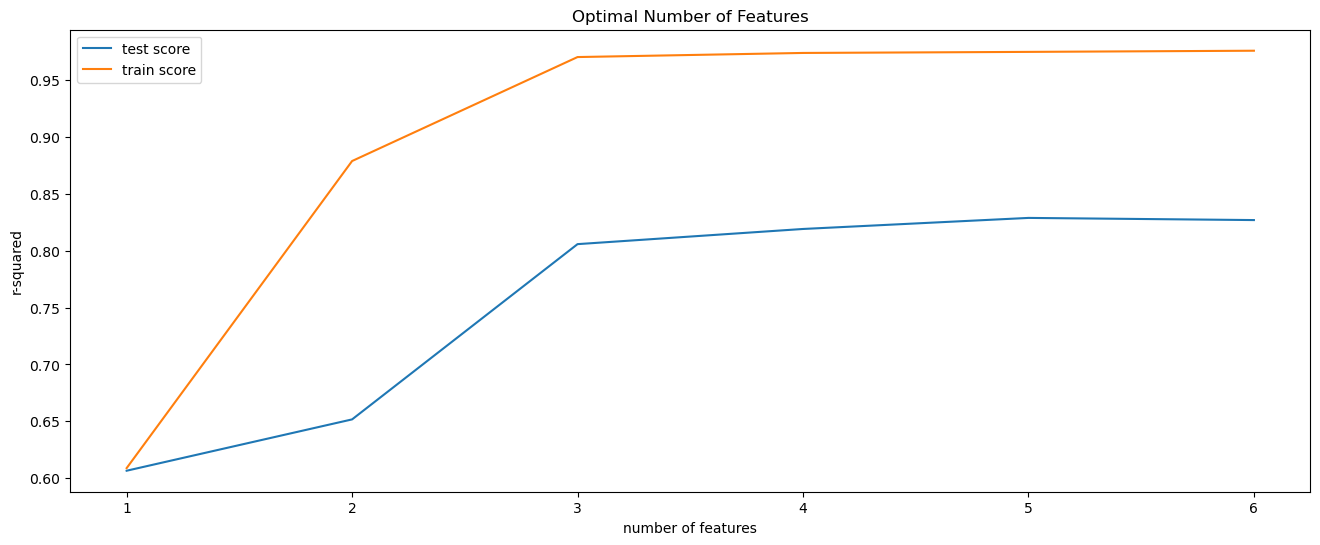

In [26]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(0, 7))}]


# step-3: perform grid search
# 3.1 specify model
lm = RandomForestRegressor()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train) 

cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [27]:
# final model
n_features_optimal = 5

lm = RandomForestRegressor()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = metrics.r2_score(y_test, y_pred)
print(r2)

0.8679537152288642


## 6. Test on User Input

In [28]:
def input_prediction(model):
    age = int(input("What is you age? (between 18-65"))
    sex = input("What is your sex? (1 for female, 0 for male)")
    bmi = int(input("what is you bmi?"))
    children = int(input ("how many children do you have?"))
    smoker = input("Are you a smoker? (1 for yes, 0 for no)")
    region = input("Where do you live? (Northeast=0, Northwest=1, Southeast=2, Southwest=3)")

    variables = (age,sex,bmi,children,smoker,region)

    variables = np.asarray(variables).reshape(1,-1)

    for i in variables:
        if variables[:,1]  == "female":
            variables[:, 1] = 1
        else:
            variables[:,1] = 0

    for i in variables:
        if variables[:,4]  == "smoker":
            variables[:, 4] = 1
        else:
            variables[:,4] = 0

    for i in variables:
        if variables[:,5]  == "northeast":
            variables[:, 5] = 0
        elif variables[:,5]  == "northwest":
            variables[:, 5] = 1
        elif variables[:,5]  == "southwest":
            variables[:, 5] = 2
        else:
            variables[:, 5] = 3

    user_input = variables.astype(float) 
    print(variables)

    prediction = model.predict(user_input)
    print("Your insurance cost would be... ", np.round(prediction[0], 2),  "USD")
    return prediction
  

In [29]:
input_prediction(model)

[['38' '0' '29' '0' '0' '3']]
Your insurance cost would be...  6745.34 USD


array([6745.34189203])

In [30]:
input_prediction(rfe)

[['38' '0' '29' '0' '0' '3']]
Your insurance cost would be...  5855.42 USD


array([5855.423937])